# Import modules & packpackages

In [83]:
import pandas as pd
import numpy as np
import re
import os
import string
from collections import defaultdict
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation # Added for LDA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print("Checking for and downloading required NLTK/Gensim data...")
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
print("All necessary data is available.")

print("Loading pre-trained word vector model (glove-wiki-gigaword-100)...")
try:
    glove_vectors = api.load('glove-wiki-gigaword-100')
except Exception as e:
    print(f"Could not load model. Please ensure you have an internet connection. Error: {e}")
    exit()
print("Model loaded successfully.")

Checking for and downloading required NLTK/Gensim data...
All necessary data is available.
Loading pre-trained word vector model (glove-wiki-gigaword-100)...


[nltk_data] Downloading package wordnet to /Users/mia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Model loaded successfully.


# Data Loading & Preprocessing

In [ ]:
SENTENCES2_TSV = 'sentences2.tsv'
SENTENCES3_TSV = 'sentences3.tsv'
LABELS1_TSV = 'labels1.tsv'
LABELS2_TSV = 'labels2.tsv'
DICTIONARY_FILENAME = "/Users/mia/Library/Mobile Documents/com~apple~CloudDocs/杜伦/Term 3/毕业论文/字典内容/Refined_dictionary.txt"


print("\n--- Loading and processing data ---")
try:
    sentence_df1 = pd.read_csv(SENTENCES2_TSV, sep='\t')
    sentence_df2 = pd.read_csv(SENTENCES3_TSV, sep='\t')
    sentences_df = pd.concat([sentence_df1, sentence_df2], ignore_index=True)
    sentences_df = sentences_df.sort_values(by=['Text-ID', 'Sentence-ID'])

    value_df1 = pd.read_csv(LABELS1_TSV, sep='\t')
    value_df2 = pd.read_csv(LABELS2_TSV, sep='\t')
    valueML_df = pd.concat([value_df1, value_df2], ignore_index=True)
    column_groups = {
        'SD': ['Self-direction: thought attained', 'Self-direction: thought constrained', 'Self-direction: action attained', 'Self-direction: action constrained'],
        'ST': ['Stimulation attained', 'Stimulation constrained'], 'HE': ['Hedonism attained', 'Hedonism constrained'],
        'AC': ['Achievement attained', 'Achievement constrained'],
        'PO': ['Power: dominance attained', 'Power: dominance constrained', 'Power: resources attained', 'Power: resources constrained'],
        'SE': ['Security: personal attained', 'Security: personal constrained', 'Security: societal attained', 'Security: societal constrained'],
        'TR': ['Tradition attained', 'Tradition constrained'],
        'CO': ['Conformity: rules attained', 'Conformity: rules constrained', 'Conformity: interpersonal attained', 'Conformity: interpersonal constrained'],
        'BE': ['Benevolence: caring attained', 'Benevolence: caring constrained', 'Benevolence: dependability attained', 'Benevolence: dependability constrained'],
        'UN': ['Universalism: concern attained', 'Universalism: concern constrained', 'Universalism: nature attained', 'Universalism: nature constrained', 'Universalism: tolerance attained', 'Universalism: tolerance constrained']
    }
    professional_df = valueML_df[['Text-ID', 'Sentence-ID']].copy()
    for main_label, sub_columns in column_groups.items():
        professional_df[main_label] = valueML_df[sub_columns].sum(axis=1, skipna=True)
    
    ALL_VALUE_TYPES = list(column_groups.keys()) 

    print(f"Text data loaded with {len(sentences_df)} records.")
    print(f"Expert score data processed for {len(professional_df)} records.")

except FileNotFoundError as e:
    print(f"ERROR: File not found: {e.filename}. Please check your file paths.")
    exit()

def read_pvd_dictionary(filepath):
    value_mapping, pvd_dict = {}, {}
    with open(filepath, 'r', encoding='utf-8') as f:
        in_header = False
        for line in f:
            line = line.strip()
            if not line: continue
            if line == '%':
                in_header = not in_header
                continue
            if in_header:
                num_str, value_str = line.split('\t')
                value_mapping[num_str] = value_str.replace('Values_', '') 
            else:
                word, num_str = line.split('\t')
                if num_str in value_mapping:
                    value_category = value_mapping[num_str] 
                    if value_category not in pvd_dict:
                        pvd_dict[value_category] = set()
                    pvd_dict[value_category].add(word.split('#')[0])
    return pvd_dict

parsed_pvd = read_pvd_dictionary(DICTIONARY_FILENAME)
print(f"PVD Dictionary loaded with {sum(len(v) for v in parsed_pvd.values())} total word entries.")


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text)    # Remove numbers
    return text

sentences_df['Cleaned_Text'] = sentences_df['Text'].apply(lambda x: clean_text(x))
print("Initial text cleaning complete.")



--- Loading and processing data ---
Text data loaded with 59662 records.
Expert score data processed for 59662 records.
PVD Dictionary loaded with 1068 total word entries.
Initial text cleaning complete.


# Data Alignment and Final Preparation

In [ ]:
master_df = pd.merge(sentences_df, professional_df, on=['Text-ID', 'Sentence-ID'])
master_df.dropna(subset=list(column_groups.keys()), inplace=True)
print(f"Merged master dataframe created with {len(master_df)} aligned records.")

aggregated_pvd = {abbr: set() for abbr in ['SD', 'ST', 'HE', 'AC', 'PO', 'SE', 'TR', 'CO', 'BE', 'UN']}
for category, words in parsed_pvd.items():
    if category in aggregated_pvd:
        aggregated_pvd[category].update(words)
    else:
        print(f"WARNING: Unknown category '{category}' in dictionary")
        
print("\n--- After Aggregation ---")
total_aggregated_words = 0
for abbr, words in aggregated_pvd.items():
    print(f"{abbr}: {len(words)} words")
    if words:
        print(f"  Sample words: {list(words)[:3]}")
    total_aggregated_words += len(words)
print(f"Total aggregated words: {total_aggregated_words}")

print("PVD dictionary aggregated to match expert score columns.")

corpus = master_df['Cleaned_Text'].tolist()
expert_scores_df = master_df[list(column_groups.keys())]

Merged master dataframe created with 59662 aligned records.

--- After Aggregation ---
SD: 140 words
  Sample words: ['schooling', 'inspiring', 'headway']
ST: 120 words
  Sample words: ['strain', 'energies', 'dramatic']
HE: 97 words
  Sample words: ['savor', 'entertain', 'sensual']
AC: 88 words
  Sample words: ['pride', 'success', 'efficient']
PO: 102 words
  Sample words: ['money', 'fancy', 'forcing']
SE: 85 words
  Sample words: ['secure', 'careful', 'surviving']
TR: 109 words
  Sample words: ['divinity', 'heavens', 'bless']
CO: 129 words
  Sample words: ['obliged', 'courtesy', 'subordinate']
BE: 95 words
  Sample words: ['loyalty', 'husband', 'dependable']
UN: 103 words
  Sample words: ['agreement', 'tolerated', 'address']
Total aggregated words: 1068
PVD dictionary aggregated to match expert score columns.


# Text Preprocessing & Tokenization Strategies

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def process_corpus_text_with_stopwords(cleaned_text, strategy='exact'):
    tokens = word_tokenize(cleaned_text)
    tokens = [word for word in tokens if word not in stop_words]

    if strategy == 'stem':
        return [stemmer.stem(word) for word in tokens]
    elif strategy == 'lemmatize':
        return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    elif strategy == 'exact':
        return tokens
    else:
        raise ValueError("Unknown tokenization strategy.")

def process_corpus_text_no_stopwords(cleaned_text, strategy='exact'):
    tokens = word_tokenize(cleaned_text)
    # No stopword removal in this path
    
    if strategy == 'stem':
        return [stemmer.stem(word) for word in tokens]
    elif strategy == 'lemmatize':
        return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    elif strategy == 'exact':
        return tokens
    else:
        raise ValueError("Unknown tokenization strategy.")

# Scoring and Ipsatisation Functions

In [ ]:
def calculate_raw_scores(processed_corpus_tokens, pvd_dict, vec_tech, vectorizer_model=None):
    num_docs = len(processed_corpus_tokens)
    scores = pd.DataFrame(0.0, index=range(num_docs), columns=pvd_dict.keys())

    if vec_tech == 'embedding_similarity':
        # This method's score is a similarity score, not a count, so it remains unchanged.
        value_vectors = {}
        for value, keywords in pvd_dict.items():
            word_vectors = [glove_vectors[word] for word in keywords if word in glove_vectors]
            if word_vectors:
                value_vectors[value] = np.mean(word_vectors, axis=0).reshape(1, -1)
        
        if not value_vectors:
            return scores

        for i, doc_tokens in enumerate(processed_corpus_tokens):
            doc_word_vectors = [glove_vectors[token] for token in doc_tokens if token in glove_vectors]
            if not doc_word_vectors: continue
            doc_vector = np.mean(doc_word_vectors, axis=0).reshape(1, -1)
            for value, value_vec in value_vectors.items():
                if value in value_vectors:
                    scores.at[i, value] = cosine_similarity(doc_vector, value_vec)[0][0]

    elif vec_tech == 'embedding_counting':
        # --- SCORING LOGIC UPDATED TO BINARY ---
        pvd_centroids = {}
        for value, keywords in pvd_dict.items():
            vectors = [glove_vectors[word] for word in keywords if word in glove_vectors]
            if vectors:
                pvd_centroids[value] = np.mean(vectors, axis=0)
        
        if not pvd_centroids:
            return scores

        value_labels = list(pvd_centroids.keys())
        centroid_matrix = np.array([pvd_centroids[label] for label in value_labels])
        threshold = 0.4

        for i, doc_tokens in enumerate(processed_corpus_tokens):
            doc_scores = {value: 0 for value in pvd_dict.keys()}
            for token in doc_tokens:
                if token in glove_vectors:
                    token_vec = glove_vectors[token].reshape(1, -1)
                    similarities = cosine_similarity(token_vec, centroid_matrix)[0]
                    max_similarity_index = np.argmax(similarities)
                    if similarities[max_similarity_index] > threshold:
                        best_match_value = value_labels[max_similarity_index]
                        doc_scores[best_match_value] += 1
            # Convert counts to binary (0 or 1)
            for value, score in doc_scores.items():
                scores.at[i, value] = 1 if score > 0 else 0

    elif vec_tech in ['bow', 'tfidf']:
        # --- SCORING LOGIC UPDATED TO BINARY ---
        vocab_map = vectorizer_model.vocabulary_
        doc_term_matrix = vectorizer_model.transform([" ".join(doc) for doc in processed_corpus_tokens]).toarray()
        for value, keywords in pvd_dict.items():
            keyword_indices = [vocab_map[word] for word in keywords if word in vocab_map]
            if not keyword_indices: continue
            # Check for presence (>0) and convert to integer (0 or 1)
            scores[value] = (doc_term_matrix[:, keyword_indices].sum(axis=1) > 0).astype(int)

    return scores

def ipsatise_scores(raw_scores_df):
    mean_scores = raw_scores_df.mean(axis=1)
    return raw_scores_df.subtract(mean_scores, axis=0)

# Evaluation Metrics

In [ ]:
def evaluate_performance(automated_scores, expert_scores):
    metrics = {}
    correlations = {}
    for value_dim in automated_scores.columns:
        auto_series = automated_scores[value_dim]
        expert_series = expert_scores[value_dim].reset_index(drop=True)
        if auto_series.std() > 0 and expert_series.std() > 0:
            corr, _ = pearsonr(auto_series, expert_series)
            correlations[value_dim] = corr if not np.isnan(corr) else 0.0
        else:
            correlations[value_dim] = 0.0
    metrics['dimensional_correlation'] = correlations
    metrics['avg_dimensional_correlation'] = np.mean(list(correlations.values()))

    profile_corrs = []
    for i in range(len(automated_scores)):
        auto_row = automated_scores.iloc[i]
        expert_row = expert_scores.iloc[i]
        if auto_row.std() > 0 and expert_row.std() > 0:
            corr, _ = pearsonr(auto_row, expert_row)
            profile_corrs.append(corr if not np.isnan(corr) else 0.0)
        else:
            profile_corrs.append(0.0)
    metrics['avg_profile_correlation'] = np.mean(profile_corrs)
    metrics['mae'] = mean_absolute_error(expert_scores, automated_scores)
    metrics['rmse'] = np.sqrt(mean_squared_error(expert_scores, automated_scores))
    return metrics


# Main Experiment Loop

In [87]:
tokenization_strategies = ['exact', 'stem', 'lemmatize']
vectorization_techniques = ['bow', 'tfidf', 'embedding_similarity', 'embedding_counting', 'lda']

results = []
all_scores = {}
best_result = {'score': -np.inf, 'config': None}

topic_to_value_map = {
    'PO': [4, 6, 7, 10, 13], 'SE': [3, 6], 'CO': [9, 10, 15],
    'UN': [5, 9, 19], 'BE': [18, 19], 'AC': [11, 12, 14, 16],
    'SD': [8, 19], 'TR': [1, 9], 'HE': [], 'ST': []
}

print("\n--- Starting 3x5 Factorial Experiment ---")

def process_dict_word(word, strategy):
    if strategy == 'stem': return stemmer.stem(word)
    elif strategy == 'lemmatize': return lemmatizer.lemmatize(word, get_wordnet_pos(word))
    return word

for token_strat in tokenization_strategies:
    print(f"\n--- Tokenization Strategy: {token_strat.upper()} ---")
    
    processed_pvd = {val: [process_dict_word(w, token_strat) for w in words] for val, words in aggregated_pvd.items()}
    pvd_vocabulary = sorted(list(set(word for words in processed_pvd.values() for word in words)))
    
    for vec_tech in vectorization_techniques:
        print(f"  > Vectorization: {vec_tech.upper()}")
        
        raw_scores = pd.DataFrame()
        combo_name = f"{token_strat}_{vec_tech}"
        
        if vec_tech == 'lda':
            processed_corpus_lda = [process_corpus_text_with_stopwords(doc, token_strat) for doc in corpus]
            lda_vectorizer = CountVectorizer(max_df=0.95, min_df=5) # Stopwords handled in processing
            doc_term_matrix_lda = lda_vectorizer.fit_transform([" ".join(doc) for doc in processed_corpus_lda])

            if doc_term_matrix_lda.shape[1] == 0:
                print("    - SKIPPING LDA due to empty vocabulary after vectorization.")
                continue

            lda_model = LatentDirichletAllocation(n_components=20, random_state=42)
            doc_topic_dist = lda_model.fit_transform(doc_term_matrix_lda)
            
            scores_df_lda_raw = pd.DataFrame(doc_topic_dist, columns=[f'Topic_{i}' for i in range(20)])
            raw_scores = pd.DataFrame(index=scores_df_lda_raw.index)
            for value, topic_indices in topic_to_value_map.items():
                if topic_indices:
                    relevant_topics = [f'Topic_{i}' for i in topic_indices]
                    raw_scores[value] = scores_df_lda_raw[relevant_topics].sum(axis=1)
                else:
                    raw_scores[value] = 0
            for value in ALL_VALUE_TYPES:
                if value not in raw_scores.columns:
                    raw_scores[value] = 0
        
        else:
            processed_corpus_dict = [process_corpus_text_no_stopwords(doc, token_strat) for doc in corpus]
            vectorizer = None
            if vec_tech in ['bow', 'tfidf']:
                if not pvd_vocabulary:
                    print(f"    - SKIPPING for '{token_strat}' due to empty vocabulary.")
                    continue
                if vec_tech == 'bow':
                    vectorizer = CountVectorizer(vocabulary=pvd_vocabulary, token_pattern=r"(?u)\b\w+\b")
                elif vec_tech == 'tfidf':
                    vectorizer = TfidfVectorizer(vocabulary=pvd_vocabulary, token_pattern=r"(?u)\b\w+\b")
                vectorizer.fit([" ".join(doc) for doc in processed_corpus_dict])
            
            raw_scores = calculate_raw_scores(processed_corpus_dict, processed_pvd, vec_tech, vectorizer)
        
        automated_ipsatised = ipsatise_scores(raw_scores)
        expert_ipsatised = ipsatise_scores(expert_scores_df)
        performance = evaluate_performance(automated_ipsatised, expert_ipsatised)

        current_score = performance['avg_dimensional_correlation']
        if not np.isnan(current_score) and current_score > best_result['score']:
            best_result['score'] = current_score
            best_result['config'] = (token_strat, vec_tech)
        
        all_scores[combo_name] = automated_ipsatised
        results.append({'tokenization': token_strat, 'vectorization': vec_tech, **performance})

print("\n--- Factorial Experiment Finished ---")


--- Starting 3x5 Factorial Experiment ---

--- Tokenization Strategy: EXACT ---
  > Vectorization: BOW
  > Vectorization: TFIDF
  > Vectorization: EMBEDDING_SIMILARITY
  > Vectorization: EMBEDDING_COUNTING
  > Vectorization: LDA

--- Tokenization Strategy: STEM ---
  > Vectorization: BOW
  > Vectorization: TFIDF
  > Vectorization: EMBEDDING_SIMILARITY
  > Vectorization: EMBEDDING_COUNTING
  > Vectorization: LDA

--- Tokenization Strategy: LEMMATIZE ---
  > Vectorization: BOW
  > Vectorization: TFIDF
  > Vectorization: EMBEDDING_SIMILARITY
  > Vectorization: EMBEDDING_COUNTING
  > Vectorization: LDA

--- Factorial Experiment Finished ---


# Results and Qualitative Analysis


--- Quantitative Evaluation Summary (Factorial Experiment) ---
   tokenization         vectorization  avg_dimensional_correlation  avg_profile_correlation     mae    rmse
0         exact                   bow                       0.1396                   0.0798  0.1790  0.3372
1         exact                 tfidf                       0.1396                   0.0798  0.1790  0.3372
2         exact  embedding_similarity                       0.1554                   0.1051  0.1460  0.2307
3         exact    embedding_counting                       0.1013                   0.0991  0.4450  0.4896
4         exact                   lda                      -0.0160                   0.0057  0.1816  0.3015
5          stem                   bow                       0.1297                   0.0843  0.2513  0.3913
6          stem                 tfidf                       0.1297                   0.0843  0.2513  0.3913
7          stem  embedding_similarity                       0.1207      

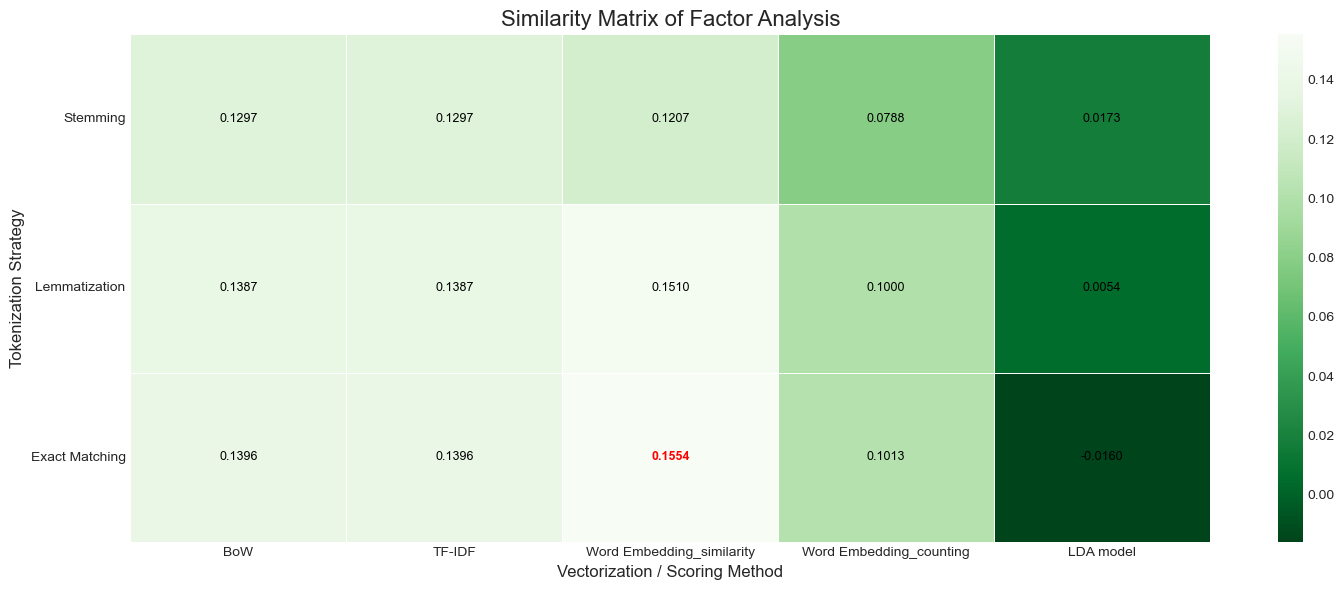

In [89]:
results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df_summary = results_df.dropna(subset=['avg_dimensional_correlation']).copy()
    
    if not results_df_summary.empty:
        corr_df = results_df_summary['dimensional_correlation'].apply(pd.Series).add_prefix('corr_')
        results_df_display = results_df_summary.drop(['dimensional_correlation'], axis=1)
        results_df_display = pd.concat([results_df_display, corr_df], axis=1)

        print("\n--- Quantitative Evaluation Summary (Factorial Experiment) ---")
        print(results_df_display[['tokenization', 'vectorization', 'avg_dimensional_correlation', 'avg_profile_correlation', 'mae', 'rmse']].round(4).to_string())

        try:
            plt.style.use('seaborn-v0_8-whitegrid')
            results_df_summary['tokenization_display'] = results_df_summary['tokenization'].map({'exact': 'Exact Matching', 'lemmatize': 'Lemmatization', 'stem': 'Stemming'}).astype(pd.api.types.CategoricalDtype(categories=['Stemming', 'Lemmatization', 'Exact Matching'], ordered=True))
            results_df_summary['vectorization_display'] = results_df_summary['vectorization'].map({'bow': 'BoW', 'tfidf': 'TF-IDF', 'embedding_similarity': 'Word Embedding_similarity', 'embedding_counting': 'Word Embedding_counting', 'lda': 'LDA model'})
            pivot_df = results_df_summary.pivot(index='tokenization_display', columns='vectorization_display', values='avg_dimensional_correlation')
            ordered_cols = ['BoW', 'TF-IDF', 'Word Embedding_similarity', 'Word Embedding_counting', 'LDA model']
            pivot_df = pivot_df[ordered_cols]

            fig, ax = plt.subplots(figsize=(15, 6))
            max_val = pivot_df.max().max()
            max_pos = divmod(pivot_df.values.argmax(), pivot_df.shape[1]) 
            sns.heatmap(pivot_df, annot=False, fmt=".4f", cmap="Greens_r", linewidths=.5, ax=ax, cbar=True)

            for i in range(pivot_df.shape[0]):
                for j in range(pivot_df.shape[1]):
                    val = pivot_df.iloc[i, j]
                    color = "red" if (i, j) == max_pos else "black"
                    ax.text(j+0.5, i+0.5, f"{val:.4f}",
                            ha='center', va='center',
                            color=color, fontsize=9, fontweight='bold' if color=='red' else 'normal')
        
            ax.set_title('Similarity Matrix of Factor Analysis', fontsize=16)
            ax.set_xlabel('Vectorization / Scoring Method', fontsize=12)
            ax.set_ylabel('Tokenization Strategy', fontsize=12)
            plt.xticks(rotation=0)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"\n[ERROR] Could not generate quantitative heatmap: {e}")

else:
    print("\nNo results were generated from the factorial experiment.")

# Batch Qualitative Analysis for ALL Combinations


--- Generating Qualitative Analysis for All 15 Combinations ---
  > Analyzing: exact_bow


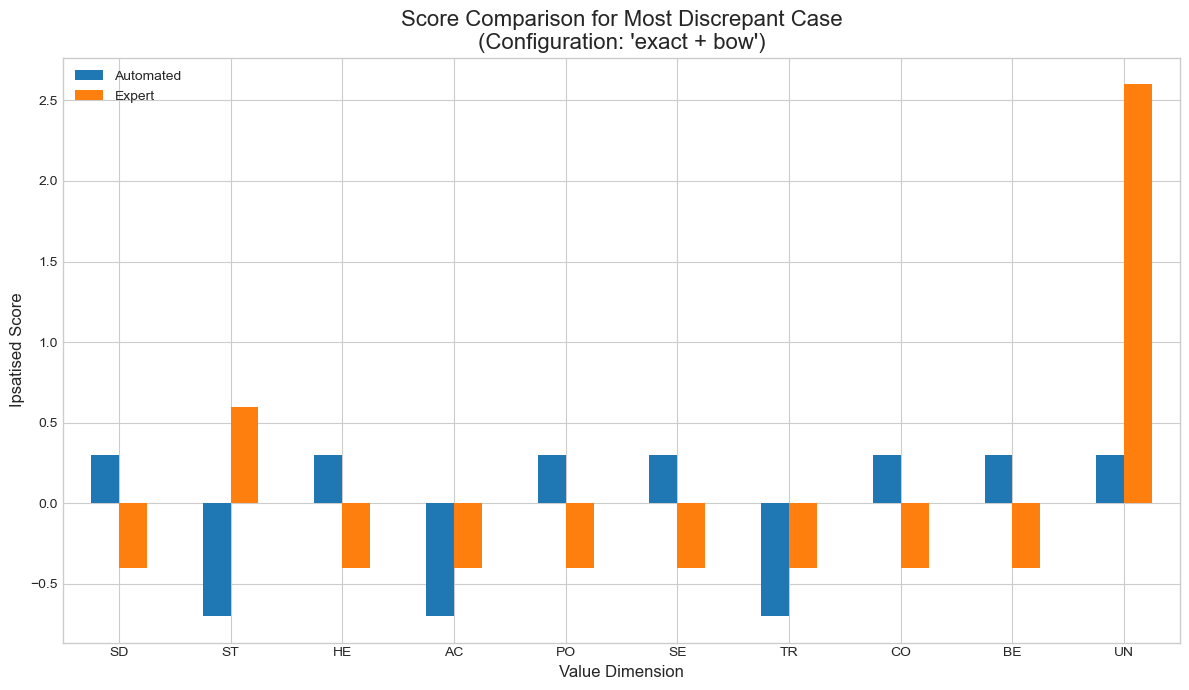

  > Analyzing: exact_tfidf


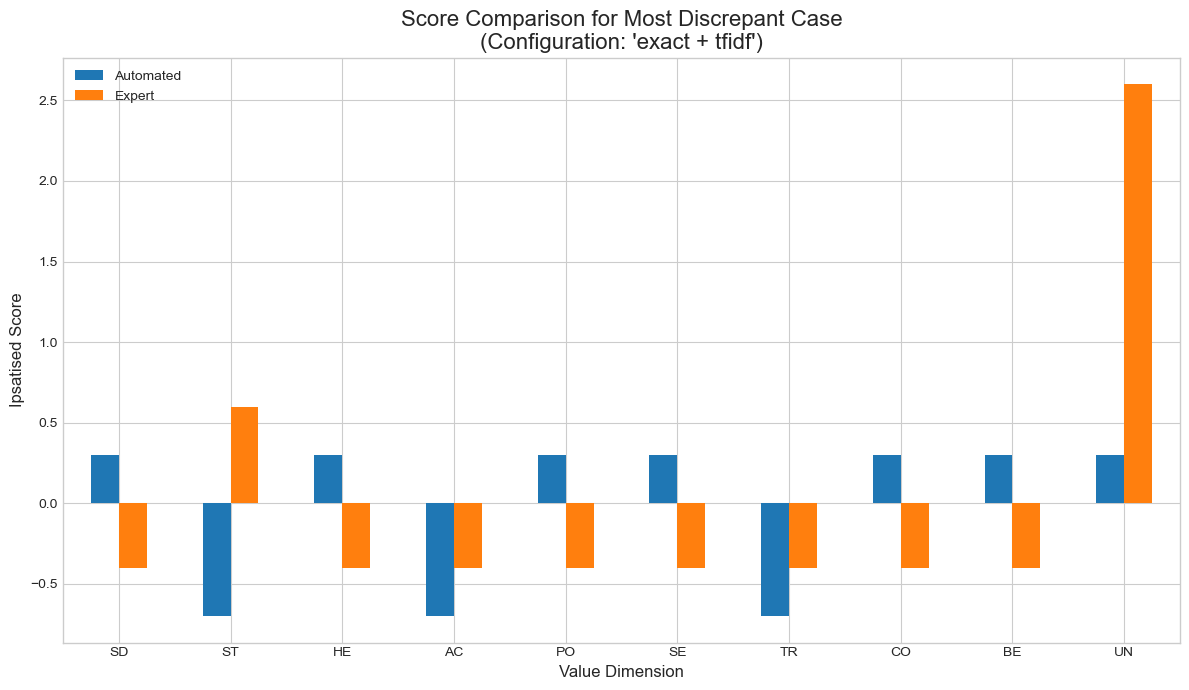

  > Analyzing: exact_embedding_similarity


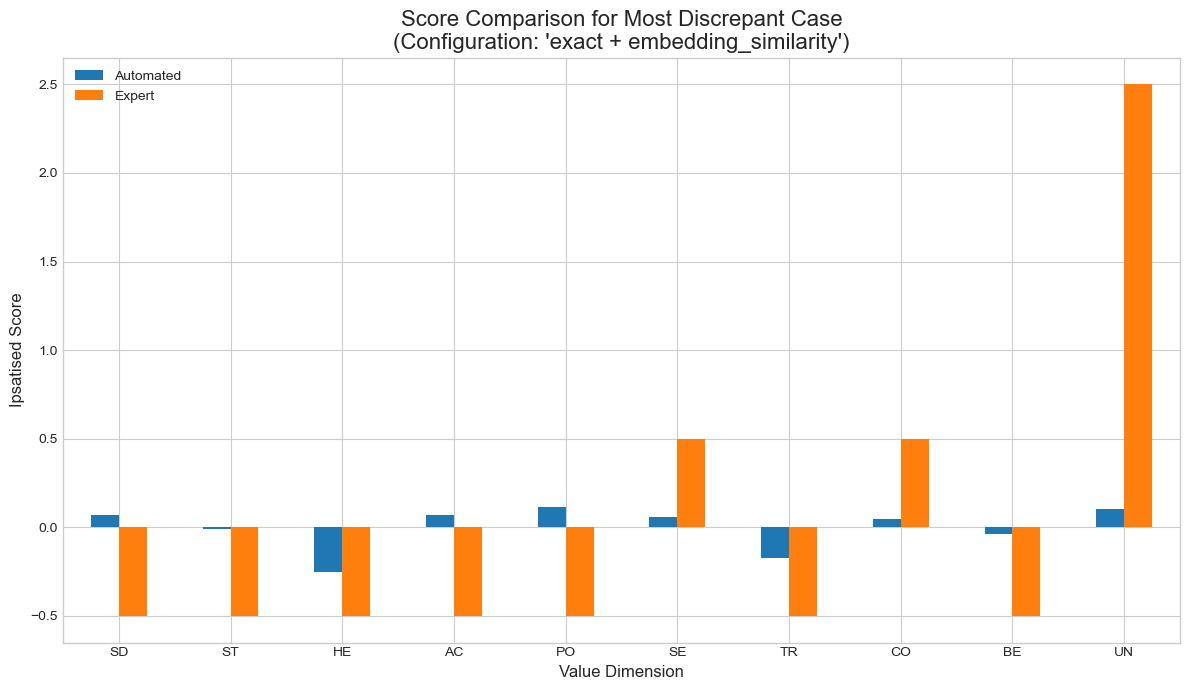

  > Analyzing: exact_embedding_counting


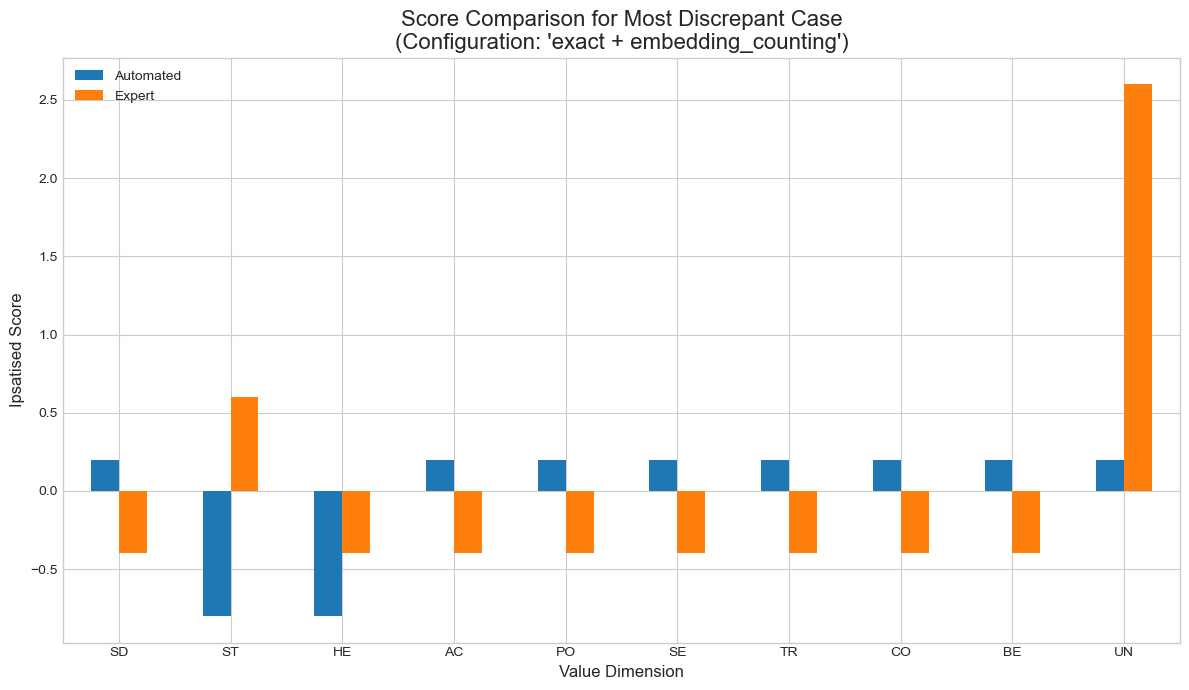

  > Analyzing: exact_lda


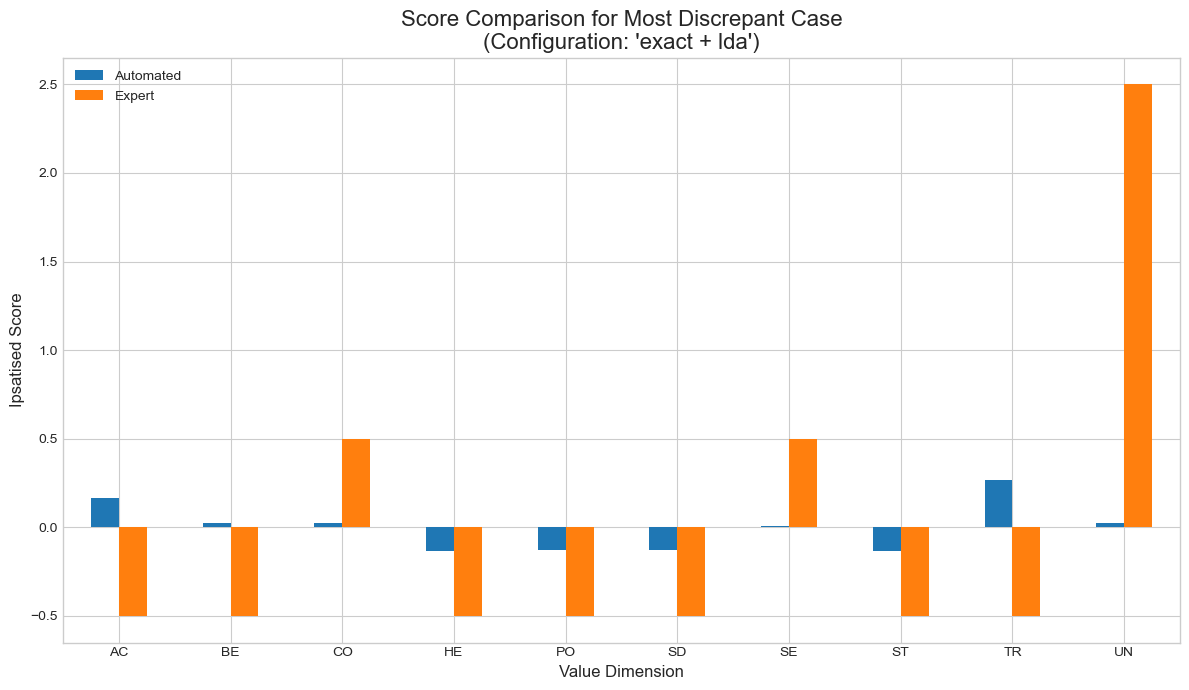

  > Analyzing: stem_bow


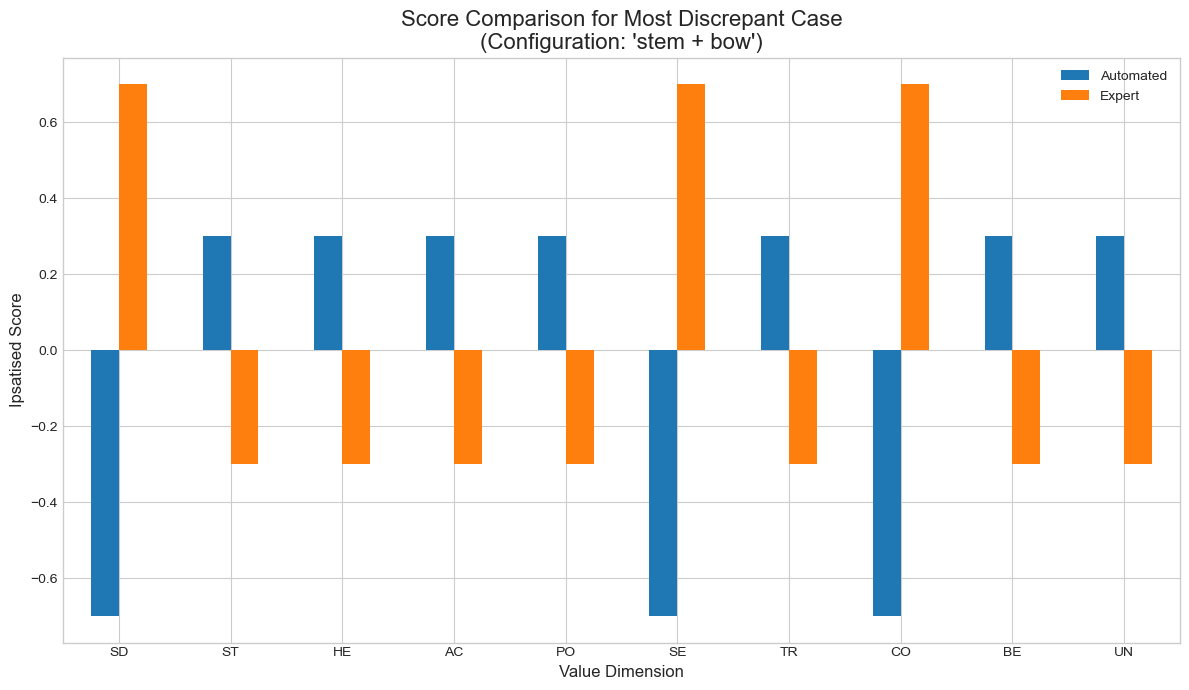

  > Analyzing: stem_tfidf


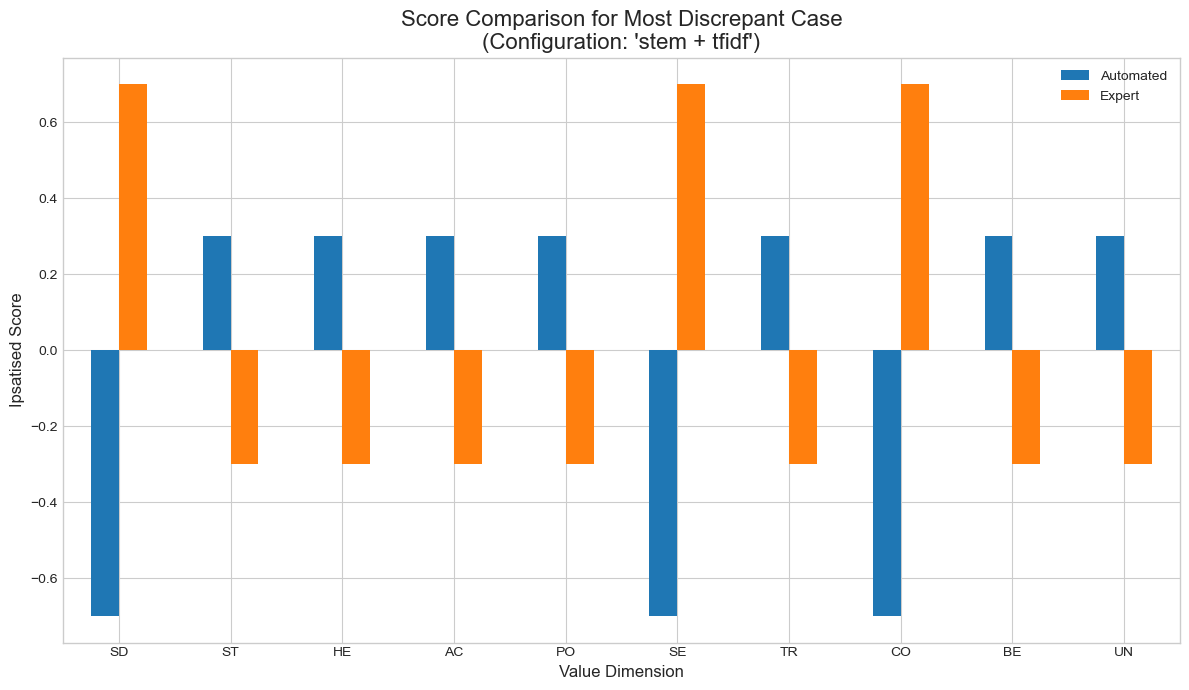

  > Analyzing: stem_embedding_similarity


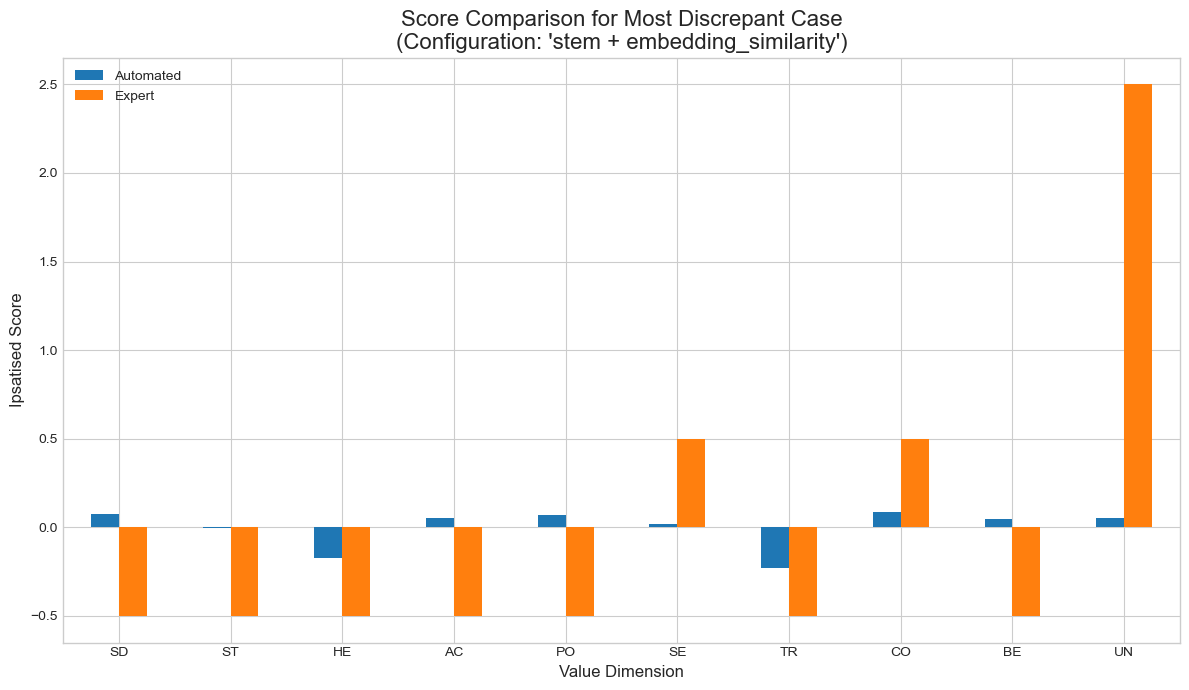

  > Analyzing: stem_embedding_counting


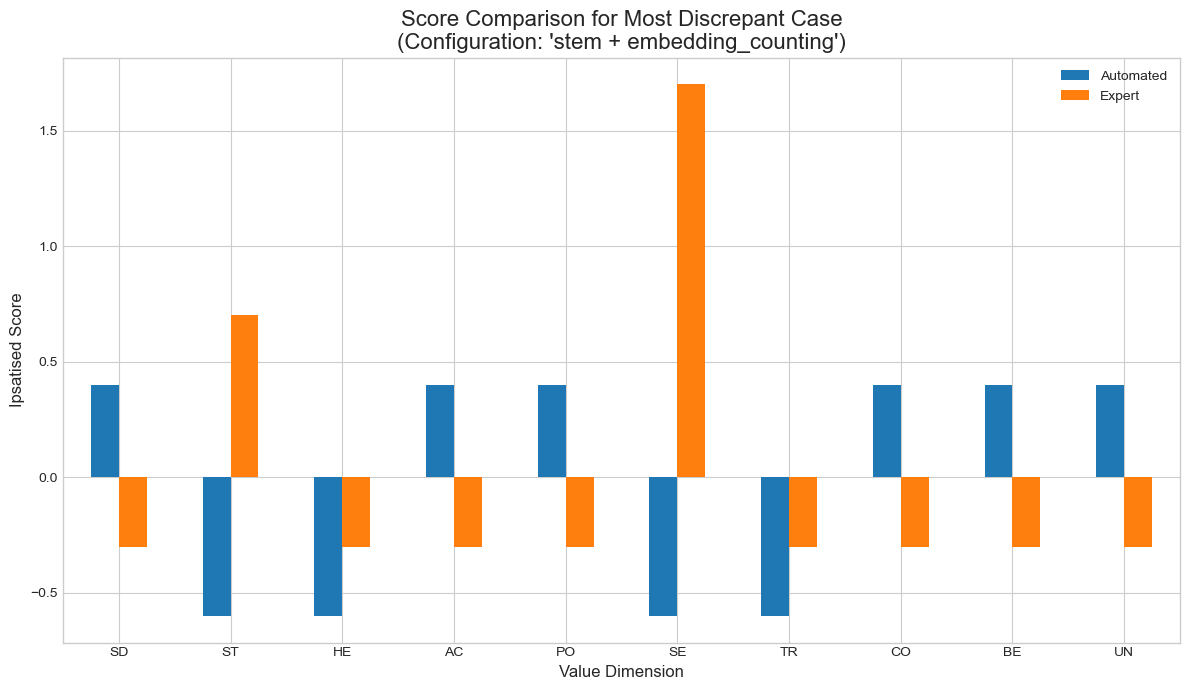

  > Analyzing: stem_lda


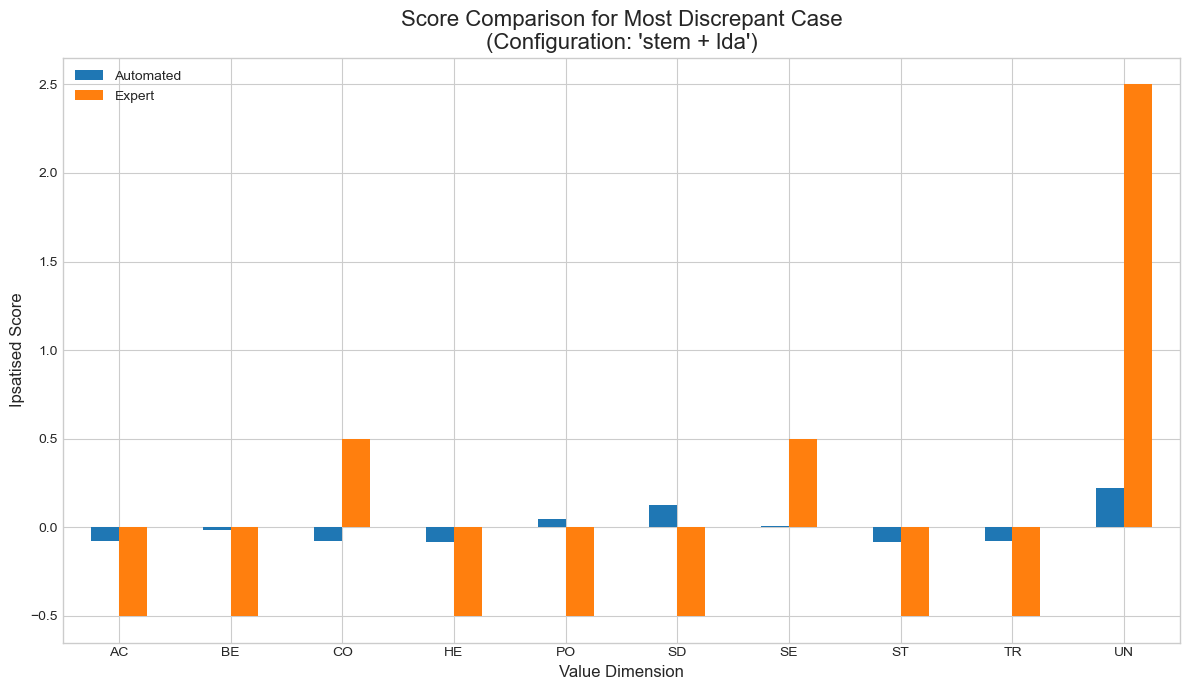

  > Analyzing: lemmatize_bow


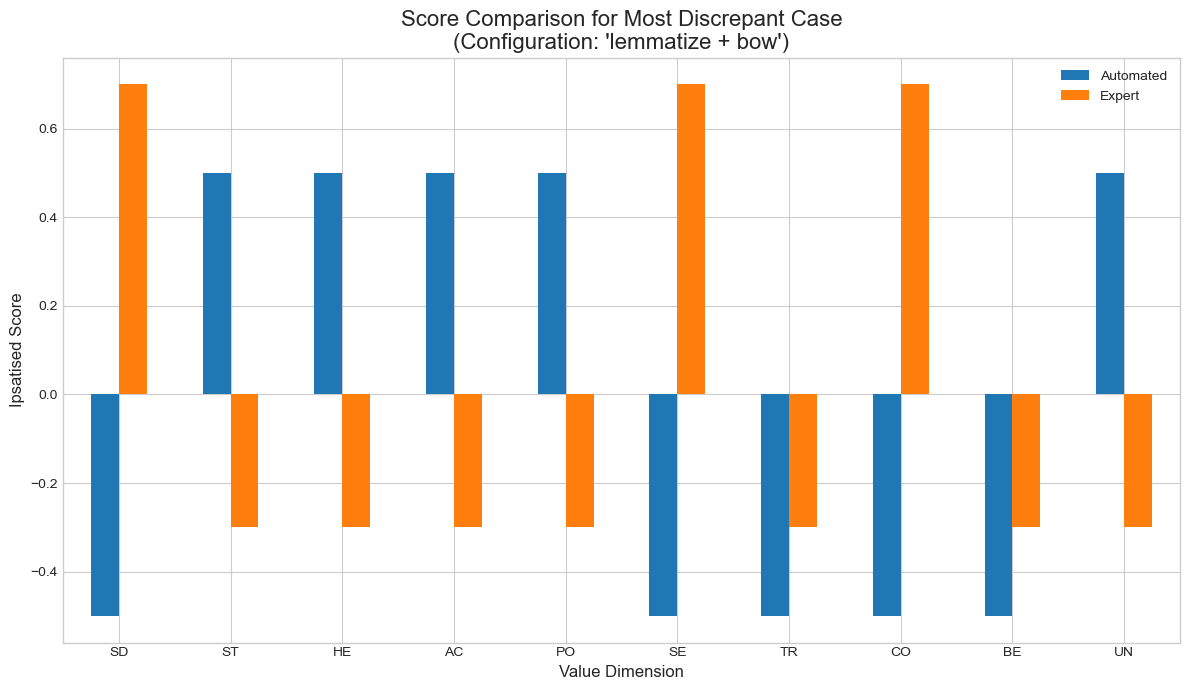

  > Analyzing: lemmatize_tfidf


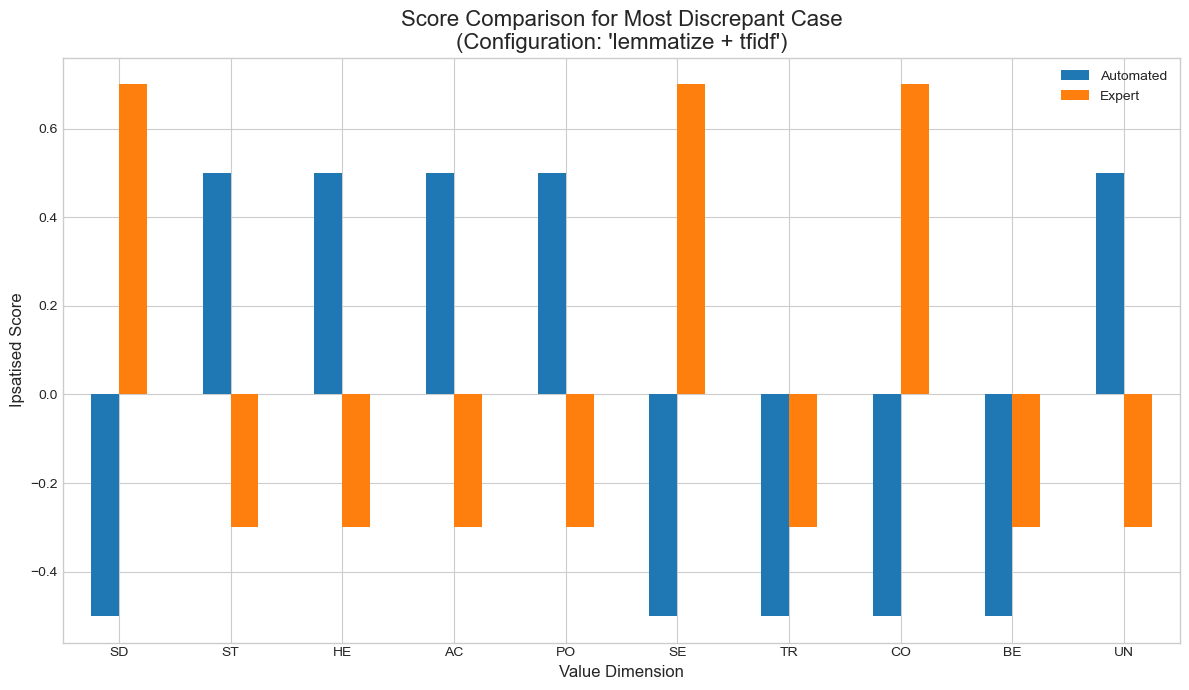

  > Analyzing: lemmatize_embedding_similarity


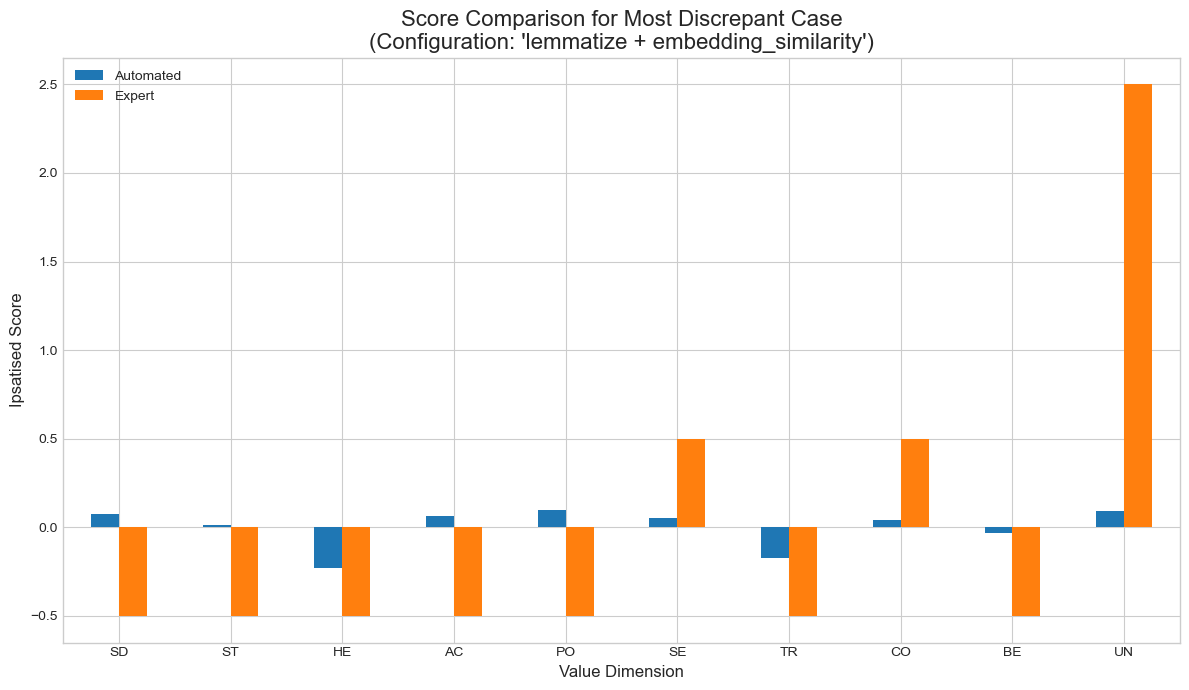

  > Analyzing: lemmatize_embedding_counting


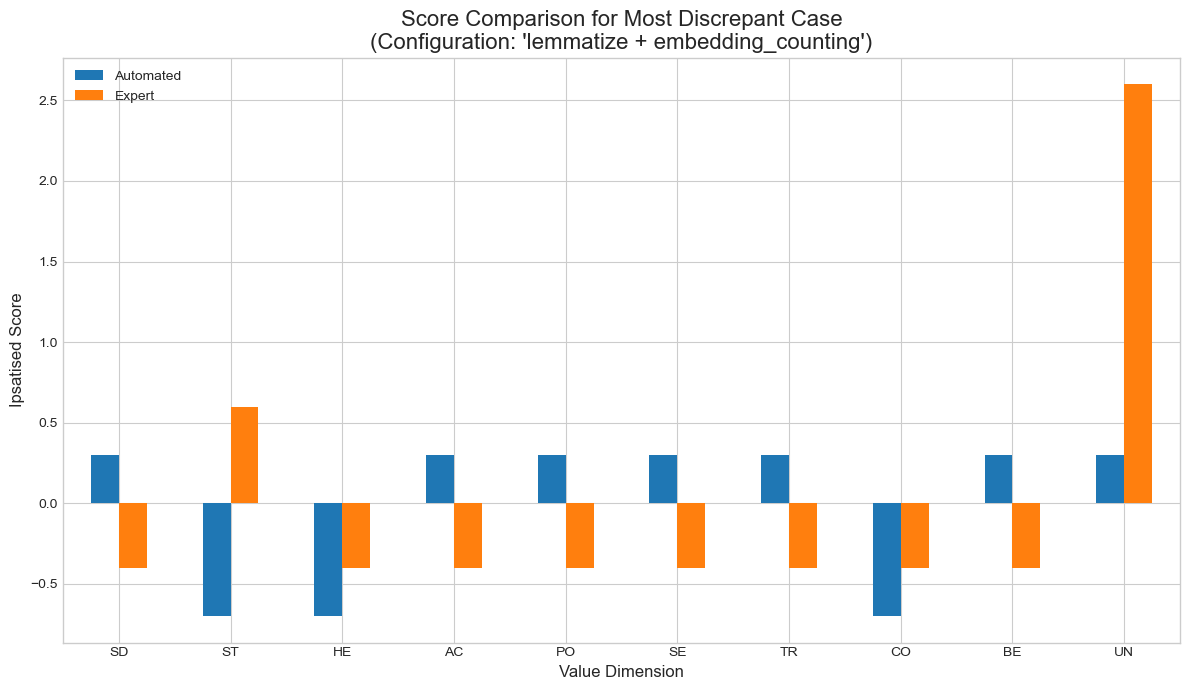

  > Analyzing: lemmatize_lda


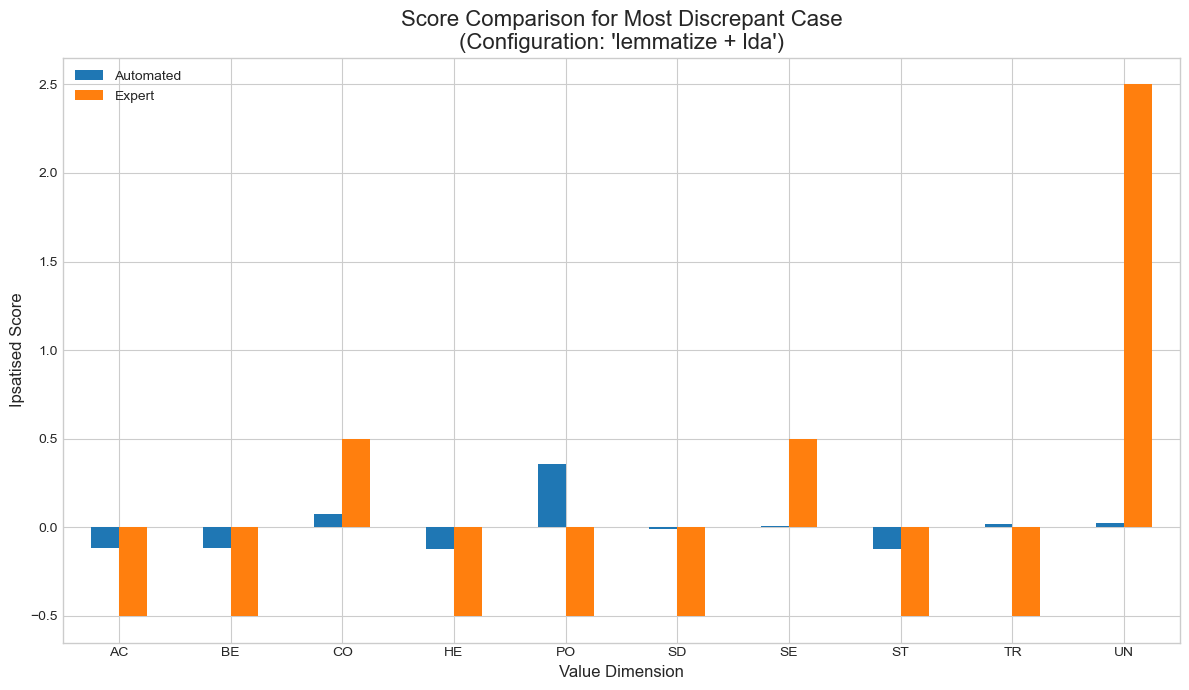

In [91]:
print("\n--- Generating Qualitative Analysis for All 15 Combinations ---")
output_dir = "qualitative_charts"
os.makedirs(output_dir, exist_ok=True)
expert_scores_best_batch = ipsatise_scores(expert_scores_df).reset_index(drop=True)

for token_strat in tokenization_strategies:
    for vec_tech in vectorization_techniques:
        combo_name = f"{token_strat}_{vec_tech}"
        
        if combo_name not in all_scores:
            print(f"  > SKIPPING Analysis for: {combo_name} (no scores found)")
            continue
            
        print(f"  > Analyzing: {combo_name}")
        auto_scores_batch = all_scores[combo_name]
        
        if auto_scores_batch.empty:
            print(f"    - SKIPPING {combo_name}, scores dataframe is empty.")
            continue

        error_diff_batch = (auto_scores_batch - expert_scores_best_batch).abs()
        total_error_per_doc_batch = error_diff_batch.sum(axis=1)
        most_discrepant_doc_idx_batch = total_error_per_doc_batch.idxmax()

        comparison_df_batch = pd.DataFrame({
            'Automated': auto_scores_batch.iloc[most_discrepant_doc_idx_batch],
            'Expert': expert_scores_best_batch.iloc[most_discrepant_doc_idx_batch],
            'Difference': error_diff_batch.iloc[most_discrepant_doc_idx_batch]
        })
        
        try:
            fig_qual_batch, ax_qual_batch = plt.subplots(figsize=(12, 7))
            comparison_df_batch[['Automated', 'Expert']].plot(kind='bar', ax=ax_qual_batch)
            ax_qual_batch.set_title(f"Score Comparison for Most Discrepant Case\n(Configuration: '{token_strat} + {vec_tech}')", fontsize=16)
            ax_qual_batch.set_xlabel('Value Dimension', fontsize=12)
            ax_qual_batch.set_ylabel('Ipsatised Score', fontsize=12)
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"\n[ERROR] Could not generate qualitative plot for {combo_name}: {e}")
